In [1]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.metrics import (
    f1_score,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    classification_report,
    roc_auc_score,
    roc_curve,
    mean_squared_error,
    mean_absolute_percentage_error,
    matthews_corrcoef,
    cohen_kappa_score
)
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the Dataset
data = pd.read_csv(r"D:\CS6501\PROJECT WORKS\Final Dataset-v.1\Dataset_3.csv")
print("Dataset Loaded:")
print(data.head())

Dataset Loaded:
   id  Time     feat1     feat2     feat3     feat4     feat5     feat6  \
0   0   0.0  2.074329 -0.129425 -1.137418  0.412846 -0.192638 -1.210144   
1   1   0.0  1.998827 -1.250891 -0.520969 -0.894539 -1.122528 -0.270866   
2   2   0.0  0.091535  1.004517 -0.223445 -0.435249  0.667548 -0.988351   
3   3   0.0  1.979649 -0.184949 -1.064206  0.120125 -0.215238 -0.648829   
4   4   0.0  1.025898 -0.171827  1.203717  1.243900 -0.636572  1.099074   

      feat7     feat8  ...    feat21    feat22    feat23    feat24    feat25  \
0  0.110697 -0.263477  ... -0.334701 -0.887840  0.336701 -0.110835 -0.291459   
1 -1.029289  0.050198  ...  0.054848 -0.038367  0.133518 -0.461928 -0.465491   
2  0.948146 -0.084789  ... -0.326725 -0.803736  0.154495  0.951233 -0.506919   
3 -0.087826 -0.035367  ... -0.095514 -0.079792  0.167701 -0.042939  0.000799   
4 -0.938651  0.569239  ...  0.099157  0.608908  0.027901 -0.262813  0.257834   

     feat26    feat27    feat28  Transaction_Amount 

In [3]:
# Dataset Overview
print("\nDataset Summary:")
print(data.describe())  # Statistical summary of the dataset
print("\nDataset Info:")
print(data.info())  # Dataset information


Dataset Summary:
                  id           Time          feat1          feat2  \
count  150000.000000  150000.000000  150000.000000  150000.000000   
mean    74999.500000   49785.422340       0.069456      -0.003674   
std     43301.414527   18733.655609       1.346553       1.161502   
min         0.000000       0.000000     -22.173926     -44.247914   
25%     37499.750000   39411.000000      -0.844248      -0.621724   
50%     74999.500000   53785.000000       0.671327       0.003677   
75%    112499.250000   63833.000000       1.171271       0.753340   
max    149999.000000   73899.000000       2.390816      16.068473   

               feat3          feat4          feat5          feat6  \
count  150000.000000  150000.000000  150000.000000  150000.000000   
mean        0.739860       0.104810      -0.254623       0.151934   
std         1.012801       1.230909       1.048268       1.182964   
min       -19.088980      -5.069484     -21.090735     -25.659750   
25%         0.1

In [4]:
# Remove Duplicate Rows
data = data.drop_duplicates()
print(f"\nDataset shape after removing duplicates: {data.shape}")


Dataset shape after removing duplicates: (150000, 32)


In [5]:
# Handle Missing Values
data.fillna(data.mean(), inplace=True)
print("Missing values handled.")

Missing values handled.


In [6]:
# Remove outliers
def remove_outliers(data):
    for col in data.select_dtypes(include=['number']).columns:
        if col != 'IsFraud':  # Do not remove rows affecting the target variable
            Q1 = data[col].quantile(0.25)
            Q3 = data[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            data = data[(data[col] >= lower_bound) | (data['IsFraud'] == 1)]
    return data

# Apply the outlier removal function
data_cleaned = remove_outliers(data)
print(f"Cleaned Dataset IsFraud Distribution:")
print(data_cleaned['IsFraud'].value_counts())

Cleaned Dataset IsFraud Distribution:
IsFraud
0    99268
1      269
Name: count, dtype: int64


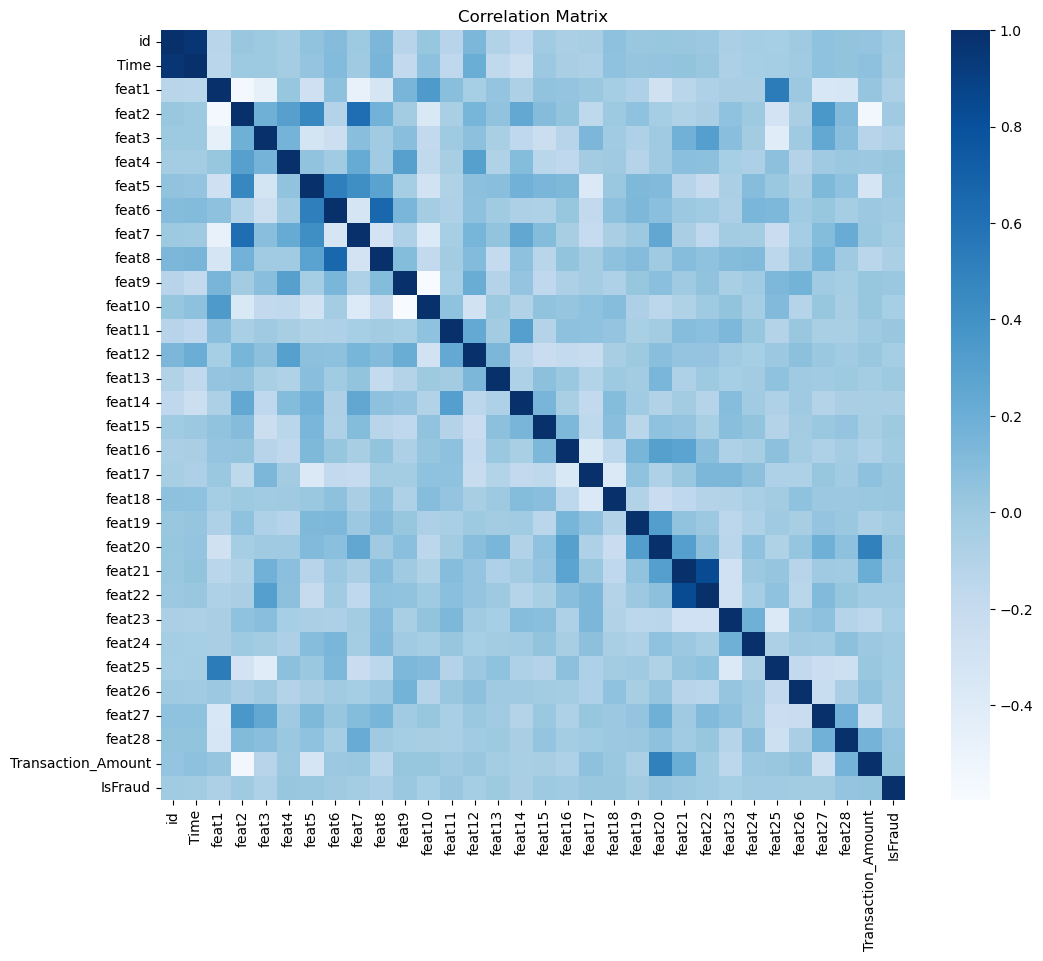

In [7]:
# Display Correlation Matrix
corr_matrix = data_cleaned.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='Blues', fmt='.2f')
plt.title("Correlation Matrix")
plt.show()

In [8]:
# Remove Highly Correlated Features
correlation_threshold = 0.9
correlated_features = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > correlation_threshold:
            correlated_features.add(corr_matrix.columns[i])

data_cleaned = data_cleaned.drop(columns=correlated_features)
print(f"\nRemoved highly correlated features: {correlated_features}")
print(f"Dataset shape after removing correlated features: {data_cleaned.shape}")


Removed highly correlated features: {'Time'}
Dataset shape after removing correlated features: (99537, 31)


In [9]:
# Separate Features and Target
X = data_cleaned.drop('IsFraud', axis=1)
y = data_cleaned['IsFraud']

In [10]:
# Handle Class Imbalance using SMOTE
print("\nOriginal Class Distribution:")
print(y.value_counts())

smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X, y)

print("\nBalanced Class Distribution:")
print(pd.Series(y_balanced).value_counts())


Original Class Distribution:
IsFraud
0    99268
1      269
Name: count, dtype: int64

Balanced Class Distribution:
IsFraud
1    99268
0    99268
Name: count, dtype: int64


In [11]:
# Scale features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [12]:
# Function for stepwise forward selection
def stepwise_forward_selection(X, y, model, max_features=10):
    selected_features = []
    remaining_features = list(X.columns)
    best_score = 0

    print("\nStepwise Forward Selection Process:")
    print(f"Initial Features: {remaining_features}")
    while remaining_features and len(selected_features) < max_features:
        scores = []
        for feature in remaining_features:
            temp_features = selected_features + [feature]
            model.fit(X[temp_features], y)
            y_pred = model.predict(X[temp_features])
            scores.append((feature, f1_score(y, y_pred, zero_division=1)))

        best_feature, best_score_candidate = max(scores, key=lambda x: x[1])
        if best_score_candidate > best_score:
            selected_features.append(best_feature)
            remaining_features.remove(best_feature)
            best_score = best_score_candidate
            print(f"Selected Feature: {best_feature}, Score: {best_score_candidate}")
            print(f"Remaining Features: {remaining_features}")
        else:
            break

    print("\nFinal Selected Features:")
    print(selected_features)
    return selected_features

In [13]:
# Sample a subset for training
X_balanced_sampled, y_balanced_sampled = X_balanced.sample(n=20000, random_state=42), y_balanced.sample(n=20000, random_state=42)

In [14]:
# Dimensionality Reduction with PCA (reduce to 15 components)
pca = PCA(n_components=15, random_state=42)
X_sampled_pca = pca.fit_transform(X_balanced_sampled)

In [15]:
# Split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X_sampled_pca, y_balanced_sampled, test_size=0.2, random_state=42, stratify=y_balanced_sampled
)

In [16]:
# Apply MinMax scaling
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [17]:
# Define and train the Linear SVM
print("\nTraining SVM with Linear Kernel...")
svm_linear = SVC(kernel='linear', probability=True, random_state=42, max_iter=10000, tol=1e-3, C=1.0)
svm_linear.fit(X_train_scaled, y_train)
y_pred_linear = svm_linear.predict(X_test_scaled)
y_prob_linear = svm_linear.predict_proba(X_test_scaled)[:, 1]


Training SVM with Linear Kernel...


In [18]:
# Define and train the RBF SVM
print("\nTraining SVM with RBF Kernel...")
svm_rbf = SVC(kernel='rbf', probability=True, random_state=42, max_iter=10000, tol=1e-3, C=1.0, gamma='scale')
svm_rbf.fit(X_train_scaled, y_train)
y_pred_rbf = svm_rbf.predict(X_test_scaled)
y_prob_rbf = svm_rbf.predict_proba(X_test_scaled)[:, 1]


Training SVM with RBF Kernel...



Accuracy: 0.7965
Precision: 0.9048
Recall: 0.6618
F1-Score: 0.7645
Matthews Correlation Coefficient: 0.6153
Cohen's Kappa Score: 0.5928


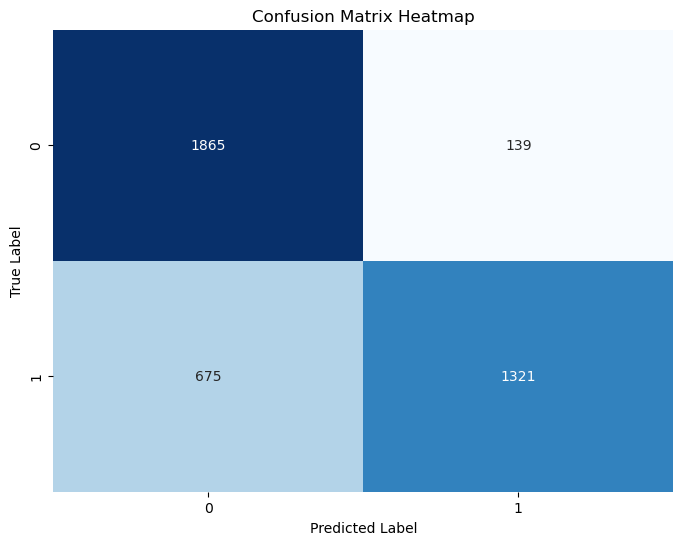

Root Mean Squared Error (RMSE): 0.4511
Residual Sum of Squares (RSS): 814.0000
Mean Absolute Percentage Error (MAPE): 156500087051124.9375
ROC-AUC Score: 0.7962


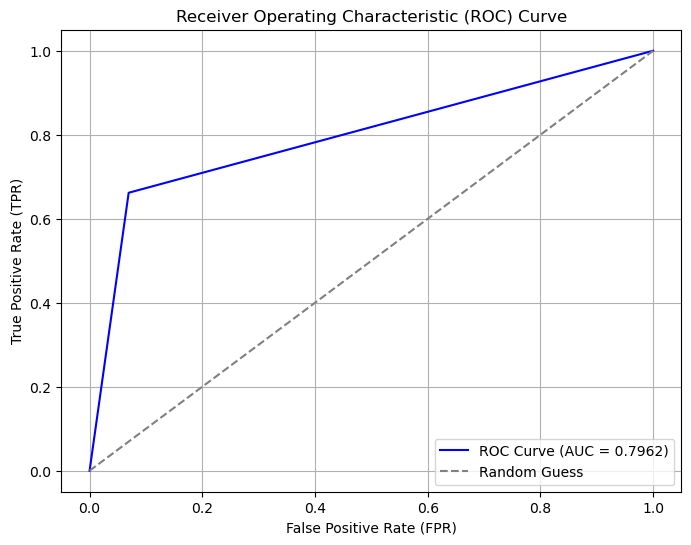

In [19]:
# Evaluate the Model for Linear

# Accuracy
accuracy = accuracy_score(y_test, y_pred_linear)
print(f"\nAccuracy: {accuracy:.4f}")

# Precision
precision = precision_score(y_test, y_pred_linear, zero_division=0)
print(f"Precision: {precision:.4f}")

# Recall
recall = recall_score(y_test, y_pred_linear, zero_division=0)
print(f"Recall: {recall:.4f}")

# F1-Score
f1 = f1_score(y_test, y_pred_linear, zero_division=0)
print(f"F1-Score: {f1:.4f}")

# Matthews Correlation Coefficient
mcc = matthews_corrcoef(y_test, y_pred_linear)
print(f"Matthews Correlation Coefficient: {mcc:.4f}")

# Cohen's Kappa Score
cohens_kappa = cohen_kappa_score(y_test, y_pred_linear)
print(f"Cohen's Kappa Score: {cohens_kappa:.4f}")

# Confusion Matrix Visualization
conf_matrix = confusion_matrix(y_test, y_pred_linear)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_linear))
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

# Residual Sum of Squares (RSS)
rss = np.sum((y_test - y_pred_linear) ** 2)
print(f"Residual Sum of Squares (RSS): {rss:.4f}")

# Mean Absolute Percentage Error (MAPE)
mape = mean_absolute_percentage_error(y_test, y_pred_linear)
print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}")

# Calculate ROC-AUC Score
roc_auc = roc_auc_score(y_test, y_pred_linear)
print(f"ROC-AUC Score: {roc_auc:.4f}")

# Generate and Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_linear)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})", color="blue")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Guess")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc="lower right")
plt.grid()
plt.show()


Accuracy: 0.8478
Precision: 0.9294
Recall: 0.7520
F1-Score: 0.8313
Matthews Correlation Coefficient: 0.7084
Cohen's Kappa Score: 0.6954


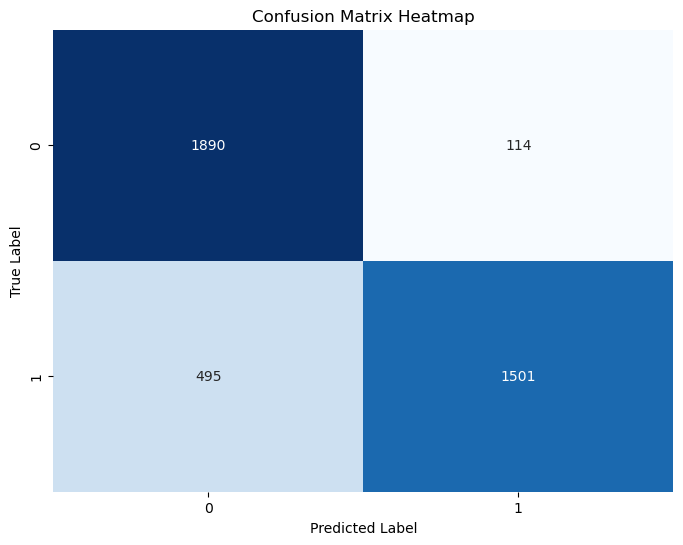

Root Mean Squared Error (RMSE): 0.3902
Residual Sum of Squares (RSS): 609.0000
Mean Absolute Percentage Error (MAPE): 128352589380059.2500
ROC-AUC Score: 0.8476


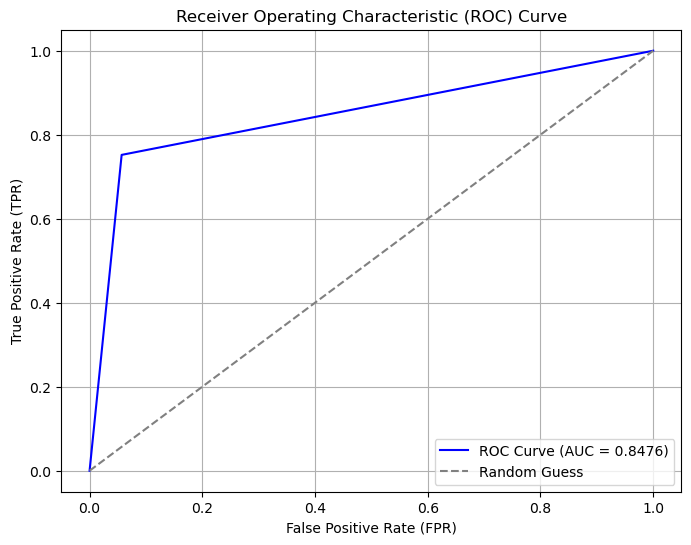

In [20]:
# Evaluate the Model for RBF

# Accuracy
accuracy = accuracy_score(y_test, y_pred_rbf)
print(f"\nAccuracy: {accuracy:.4f}")

# Precision
precision = precision_score(y_test, y_pred_rbf, zero_division=0)
print(f"Precision: {precision:.4f}")

# Recall
recall = recall_score(y_test, y_pred_rbf, zero_division=0)
print(f"Recall: {recall:.4f}")

# F1-Score
f1 = f1_score(y_test, y_pred_rbf, zero_division=0)
print(f"F1-Score: {f1:.4f}")

# Matthews Correlation Coefficient
mcc = matthews_corrcoef(y_test, y_pred_rbf)
print(f"Matthews Correlation Coefficient: {mcc:.4f}")

# Cohen's Kappa Score
cohens_kappa = cohen_kappa_score(y_test, y_pred_rbf)
print(f"Cohen's Kappa Score: {cohens_kappa:.4f}")

# Confusion Matrix Visualization
conf_matrix = confusion_matrix(y_test, y_pred_rbf)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_rbf))
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

# Residual Sum of Squares (RSS)
rss = np.sum((y_test - y_pred_rbf) ** 2)
print(f"Residual Sum of Squares (RSS): {rss:.4f}")

# Mean Absolute Percentage Error (MAPE)
mape = mean_absolute_percentage_error(y_test, y_pred_rbf)
print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}")

# Calculate ROC-AUC Score
roc_auc = roc_auc_score(y_test, y_pred_rbf)
print(f"ROC-AUC Score: {roc_auc:.4f}")

# Generate and Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_rbf)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})", color="blue")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Guess")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [21]:
# Check for overfitting or underfitting with SVM (Linear Kernel)
train_accuracy = accuracy_score(y_train, svm_linear.predict(X_train_scaled))
test_accuracy = accuracy_score(y_test, y_pred_linear)

# Print accuracy scores
print(f"Training Accuracy (Linear Kernel): {train_accuracy:.4f}")
print(f"Testing Accuracy (Linear Kernel): {test_accuracy:.4f}")

# Determine model behavior
if train_accuracy > test_accuracy + 0.1:  
    print("The model might be overfitting (high training accuracy, low testing accuracy).")
elif test_accuracy > train_accuracy + 0.1:
    print("The model might be underfitting (low accuracy on both training and testing sets).")
else:
    print("The model appears to be well-fitted.")

Training Accuracy (Linear Kernel): 0.7998
Testing Accuracy (Linear Kernel): 0.7965
The model appears to be well-fitted.


In [22]:
# Check for overfitting or underfitting with SVM (RBF Kernel)
train_accuracy = accuracy_score(y_train, svm_rbf.predict(X_train_scaled))
test_accuracy = accuracy_score(y_test, y_pred_rbf)

# Print accuracy scores
print(f"Training Accuracy (RBF Kernel): {train_accuracy:.4f}")
print(f"Testing Accuracy (RBF Kernel): {test_accuracy:.4f}")

# Determine model behavior
if train_accuracy > test_accuracy + 0.1:  
    print("The model might be overfitting (high training accuracy, low testing accuracy).")
elif test_accuracy > train_accuracy + 0.1:
    print("The model might be underfitting (low accuracy on both training and testing sets).")
else:
    print("The model appears to be well-fitted.")

Training Accuracy (RBF Kernel): 0.8504
Testing Accuracy (RBF Kernel): 0.8478
The model appears to be well-fitted.
